## Regresor

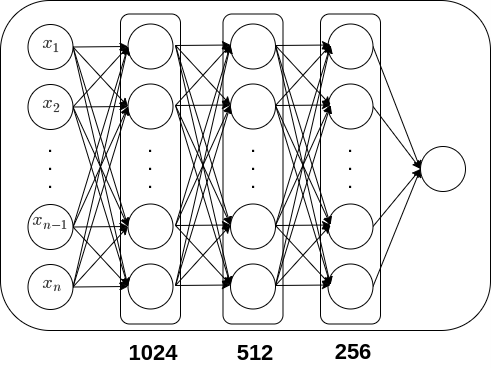

In [ ]:
#Librerías
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

%store -r

In [ ]:
# Para leer los datos
data_file = "../BasesDeDatos/CaractFCM.csv"
df = pl.read_csv(data_file, dtypes=[pl.Float64], has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_B2B = df[0:987, :]
# Datos con fibra óptica a 0dBm
df_fiber_0 = df[988:1520, :]
# Datos con fibra óptica a 9dBm
df_fiber_9 = df[1521:, :]

In [ ]:
def estimation_model(input_dim, layers_props_lst):
    model = ker.Sequential()
    # Capas ocultas
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regresor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    # Compilar modelo
    model.compile(loss="mean_absolute_error", optimizer="adam")

    return model


def crossvalidation(X, y, n_splits, layer_props, callbacks):
    # Para calcular el tiempo que tarda
    t0 = time()

    # Diccionario donde se almacenarán los puntajes
    scores = {}
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    
    # Se hace un K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarización de las variables de entrada
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props)
        # Guardar la pérdida escalar de prueba (Test scalar loss)
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Iteraciones necesarias: {len(loss.history['loss'])}")
        
        # Se predice con los datos de entrenamiento
        predictions_train = model.predict(X_train)
        # Se predice con los datos de prueba
        predictions_test = model.predict(X_test_kf)

        # Se crea un dataframe con los resultados para visualizarlos mejor
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Cálculo del MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Cálculo de R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Anexo a las listas
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
    print(f"Tiempo transcurrido: {(time() - t0)/60:.2f} minutos")

    return scores


def test_model(data, n_splits, max_neurons, activations):
    """ Probar un modelo con parámetros establecidos. """
    variables = 17

    # Separando variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Etiquetas
    y = np.array(data[:, 19:20]).T
    
    # Propiedades de las capas
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=300, mode="min", restore_best_weights=True)
    ]
    
    return crossvalidation(X, y, n_splits, layer_props, callbacks)


def smooth_line(x, y):
    x_smooth = np.linspace(x[0], x[-1], 1000)
    bspline = sp.interpolate.make_interp_spline(x, y)
    y_smooth = bspline(x_smooth)

    return x_smooth, y_smooth


def plot_scores(scores, max_neurons):
    score_names = ["mae", "r2"]
    data_type = ["train", "test"]
    
    plt.figure(figsize=(16, 6*len(scores)))
    
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(4, 1, i + 1)
            for score, neurons in zip(scores, max_neurons):  
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8)
                 
                x, y = smooth_line(k, points)
                plt.scatter(k, points, marker="x")
                plt.plot(x, y, label=f"Máximas neuronas = {neurons}, µ = {np.mean(points):.4f}", ls="dashed")
                
            plt.title(f"Datos de {'entrenamiento' if dt == 'train' else 'prueba'}")
            plt.xlabel("k-fold")
            plt.ylabel("MAE" if sn == "mae" else "R²")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1


def calc_once(varname, fn, args):
    """ Calcular una variable una sola vez. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

## Crosvalidación para B2B variando el número de neuronas por capa

In [ ]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_B2B = calc_once("scores_1024_B2B", test_model, args)

In [ ]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_B2B = calc_once("scores_512_B2B", test_model, args)

In [ ]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_B2B = calc_once("scores_256_B2B", test_model, args)

In [ ]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_B2B = calc_once("scores_128_B2B", test_model, args)

In [ ]:
%store scores_1024_B2B scores_512_B2B scores_256_B2B scores_128_B2B

### Gráficas de puntajes

In [ ]:
scores = [scores_1024_B2B, scores_512_B2B, scores_256_B2B, scores_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 0dBm variando el número de neuronas por capa

In [ ]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_fiber_0 = calc_once("scores_1024_fiber_0", test_model, args)

In [ ]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_fiber_0 = calc_once("scores_512_fiber_0", test_model, args)

In [ ]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_fiber_0 = calc_once("scores_256_fiber_0", test_model, args)

In [ ]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_fiber_0 = calc_once("scores_128_fiber_0", test_model, args)

In [ ]:
%store scores_1024_fiber_0 scores_512_fiber_0 scores_256_fiber_0 scores_128_fiber_0

## Gráficas de puntajes

In [ ]:
scores = [scores_1024_fiber_0, scores_512_fiber_0, scores_256_fiber_0, scores_128_fiber_0]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 9dBm variando el número de neuronas por capa

In [ ]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_fiber_9 = calc_once("scores_1024_fiber_9", test_model, args)

In [ ]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_fiber_9 = calc_once("scores_512_fiber_9", test_model, args)

In [ ]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_fiber_9 = calc_once("scores_256_fiber_9", test_model, args)

In [ ]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_fiber_9 = calc_once("scores_128_fiber_9", test_model, args)

In [ ]:
%store scores_1024_fiber_9 scores_512_fiber_9 scores_256_fiber_9 scores_128_fiber_9

## Gráficas de puntajes

In [ ]:
scores = [scores_1024_fiber_9, scores_512_fiber_9, scores_256_fiber_9, scores_128_fiber_9]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

# Validación cruzada con los datos de Natalia
# Variar los parámetros de las redes neuronales
# Variar el número de neuronas (1024, 512, 256)/8, (1024, 512, 256)/4, (1024, 512, 256)/2, (1024, 512, 256)
# Variar las funciones de activación con el mejor resultado del número de neuronas
# Variar el número de capas ocultas (1 a 4 capas)